<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_ts_data.csv').drop(columns=['Unnamed: 0'])

feature_list = list(set(df.columns) - set(['Address', 'Index', 'FLAG']))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['FLAG'])

In [4]:
print("Number of training samples: ", df_train.shape[0])
print("Number of Test samples: ", df_test.shape[0])

Number of training samples:  11136
Number of Test samples:  2784


In [5]:
%run "/content/drive/MyDrive/ethereum-fraud-detection/models/helper_data_preprocessing.py"

In [6]:
dp = DataPrep(
    features=feature_list,
    fill_strategy='median',
    upper_clip_quantile=0.95,
    lower_clip_quantile=0.05
)

In [7]:
df_train_prep = dp.fit_transform(df_train)
df_test_prep = dp.transform(df_test)

In [8]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [9]:
svm_clf = SVC(random_state=42, probability=True)

params = {
    "kernel": ['rbf'],
    "gamma": [1],
    "C": [100],
}

clf = GridSearchCV(estimator=svm_clf,
                   param_grid=params,
                   cv=5,
                   n_jobs=-1,
                   scoring='f1')
clf.fit(df_train_prep, df_train['FLAG'])

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [100], 'gamma': [1], 'kernel': ['rbf']},
             scoring='f1')

In [10]:
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [11]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.9959031367494593
test roc_auc_score:  0.9352440999687931


In [12]:
y_pred = clf.predict(df_test_prep)

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}\nROC AUC: {}".format(
    f1_score(df_test['FLAG'], y_pred),
    recall_score(df_test['FLAG'], y_pred),
    accuracy_score(df_test['FLAG'], y_pred),
    precision_score(df_test['FLAG'], y_pred),
    roc_auc_score(df_test['FLAG'], y_pred))
)

F1 Score: 0.8417858690940615
Recall: 0.7724741447891806
Accuracy: 0.8688936781609196
Precision: 0.9247619047619048
ROC AUC: 0.8603693579217677


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1527
           1       0.92      0.77      0.84      1257

    accuracy                           0.87      2784
   macro avg       0.88      0.86      0.86      2784
weighted avg       0.88      0.87      0.87      2784



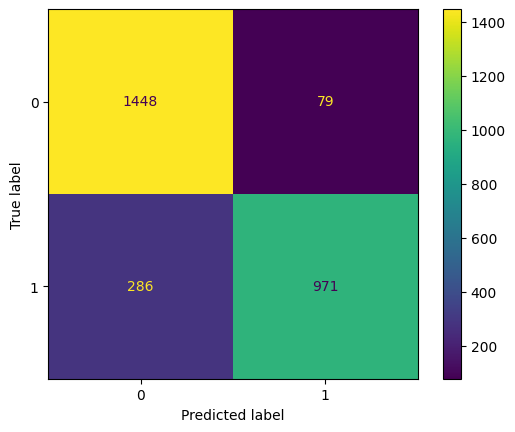

In [13]:
print(classification_report(df_test['FLAG'], y_pred))
cm = confusion_matrix(df_test['FLAG'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
disp.plot()
plt.show()

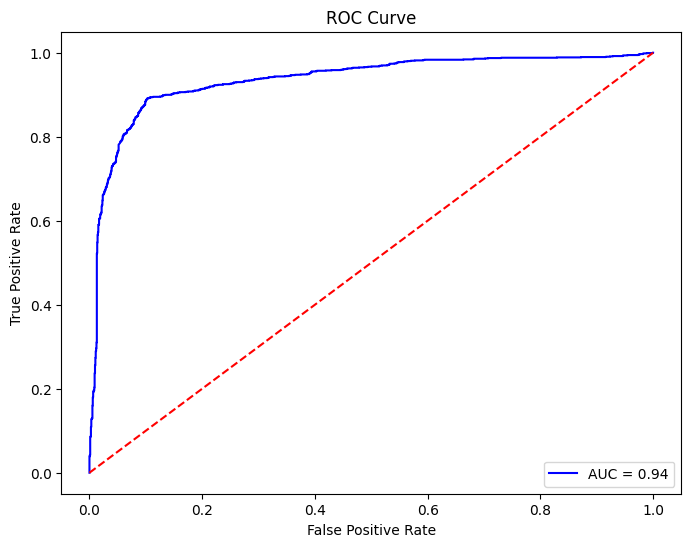

In [14]:
y_pred = clf.predict_proba(df_test_prep)[:, 1]
fpr, tpr, threshold = roc_curve(df_test['FLAG'], y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

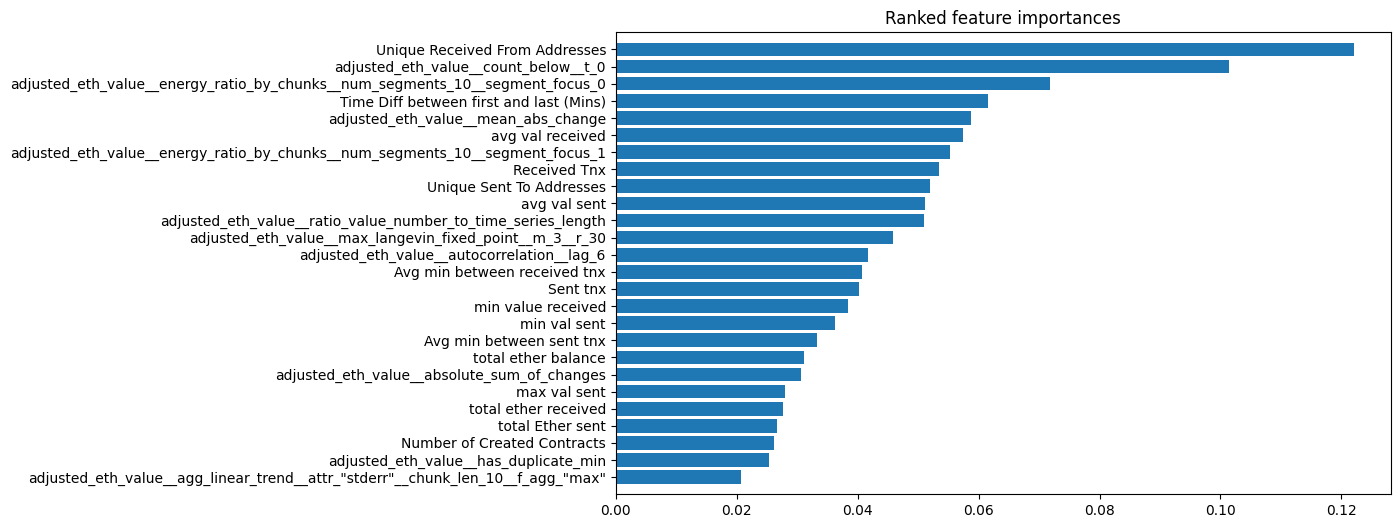

In [15]:
# if kernel is linear
# feat_importances = clf.best_estimator_.coef_[0]

# if kernel is not linear
from sklearn.inspection import permutation_importance
result = permutation_importance(clf.best_estimator_, df_test_prep, df_test['FLAG'], n_repeats=10, random_state=42)
feat_importances = result.importances_mean

indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [16]:
# Save the model
pickle_out = open('/content/drive/MyDrive/ethereum-fraud-detection/saved-models/svm.pickle', 'wb')
pickle.dump(clf, pickle_out)
pickle_out.close()